# Example Binder

This is a test binder. I used it to develop documentation on how to make binders so that the technology is more accessible to instructors and researchers everywhere.

I will be accessing Landsat 8 data under the AWS Public Dataset Program: https://registry.opendata.aws/landsat-8/

Launching the binder happens on AWS, so this should make it easier to load the data in cloud.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline

import xarray as xr
import intake

from dask_kubernetes import KubeCluster
from dask.distributed import Client, LocalCluster
from dask.distributed import wait, progress

## Setup

Two things we want to set up before we can do any analysis, which are both usually huge time-sinks.

### Dask: Computational Power

Dask will allow us to spin up a Kubernetes cluster on our AWS instance. This cluster can scale how many workers it uses when you run commands, so you can have faster computations but not pay for that resource when you're not using it.

In [2]:
cluster = KubeCluster()
cluster.adapt(minimum=4, maximum=40)
cluster

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at: tcp://192.168.100.254:34429
distributed.scheduler - INFO -   dashboard at:                     :8787


KubeCluster('tcp://192.168.100.254:34429', workers=0, threads=0, memory=0 B)

Task exception was never retrieved
future: <Task finished coro=<_wrap_awaitable() done, defined at /srv/conda/envs/notebook/lib/python3.7/asyncio/tasks.py:596> exception=AssertionError()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/asyncio/tasks.py", line 603, in _wrap_awaitable
    return (yield from awaitable.__await__())
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/deploy/spec.py", line 42, in _
    assert self.status == "running"
AssertionError
Task exception was never retrieved
future: <Task finished coro=<_wrap_awaitable() done, defined at /srv/conda/envs/notebook/lib/python3.7/asyncio/tasks.py:596> exception=AssertionError()>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/asyncio/tasks.py", line 603, in _wrap_awaitable
    return (yield from awaitable.__await__())
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/deploy/spec.py", line 42, in _
    assert se

In [ ]:
client = Client(cluster)

### Intake: Data Ingestion

One big problem with big data is that it is too big for most conventional laptops (which is what most researchers have). Getting onto a High-Performance Computer (HPC) can take a lot of time and authentication, which delays research. Having data on publicly-available cloud platforms removes the stress of setting up access, and computing on the same platform removes most of the time to get to your data.

In [3]:
landsat_data_url = 'https://landsat-pds.s3.amazonaws.com/c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/LC08_L1TP_139045_20170304_20170316_01_T1_B8.TIF'
landsat_catalog_url = 's3://landsat-pds/scene_list.gz/'
landsat_catalog_url_2 = 'https://landsat-pds.s3.amazonaws.com/c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/*.TIF'
#landsat_data = intake.open_xarray_image(landsat_data_url, )

I think I have the catalog here, but I don't know what I can do with it yet.

In [ ]:
landsat_catalog = intake.open_catalog(landsat_catalog_url)

In [ ]:
landsat_catalog

In [ ]:
list(landsat_catalog)

In [ ]:
landsat_catalog_2 = intake.open_catalog(landsat_catalog_url_2)

In [ ]:
landsat_catalog_2

In [ ]:
list(landsat_catalog_2)

In [ ]:
landsat_catalog_2.read_chunked()

Try Rasterio catalog?

In [3]:
landsat_catalog_rast = intake.open_rasterio(landsat_catalog_url_2, chunks={})

In [4]:
landsat_catalog_rast

In [5]:
landsat_catalog_rast.read_chunked()

Exception: No files found at https://landsat-pds.s3.amazonaws.com/c1/L8/139/045/LC08_L1TP_139045_20170304_20170316_01_T1/*.TIF

## Read in data with rasterio

Rasterio to the rescue! Now I can actually read the data and see some of it. This is only one band, tho.

In [4]:
landsat_data = xr.open_rasterio(landsat_data_url, chunks={})

In [5]:
landsat_data

<xarray.DataArray (band: 1, y: 15541, x: 15221)>
dask.array<open_rasterio-5f88811e342a52c78e34ce846e4ca86a<this-array>, shape=(1, 15541, 15221), dtype=uint16, chunksize=(1, 15541, 15221), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 2.512e+06 2.512e+06 2.512e+06 ... 2.279e+06 2.279e+06
  * x        (x) float64 3.822e+05 3.822e+05 3.822e+05 ... 6.105e+05 6.105e+05
Attributes:
    transform:      (15.0, 0.0, 382192.5, 0.0, -15.0, 2512507.5)
    crs:            +init=epsg:32645
    res:            (15.0, 15.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Point

In [6]:
landsat_data.dims

('band', 'y', 'x')

In [7]:
landsat_data.attrs

{'transform': (15.0, 0.0, 382192.5, 0.0, -15.0, 2512507.5),
 'crs': '+init=epsg:32645',
 'res': (15.0, 15.0),
 'is_tiled': 1,
 'nodatavals': (nan,),
 'scales': (1.0,),
 'offsets': (0.0,),
 'AREA_OR_POINT': 'Point'}

In [8]:
landsat_data.data

dask.array<open_rasterio-5f88811e342a52c78e34ce846e4ca86a<this-array>, shape=(1, 15541, 15221), dtype=uint16, chunksize=(1, 15541, 15221), chunktype=numpy.ndarray>

In [9]:
landsat_data[0, 0, :].values

array([0, 0, 0, ..., 0, 0, 0], dtype=uint16)

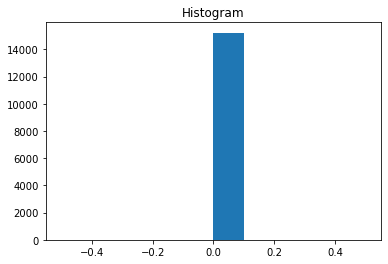

In [10]:
_ = landsat_data[0, 0, :].plot.hist()

In [11]:
landsat_data['band']

<xarray.DataArray 'band' (band: 1)>
array([1])
Coordinates:
  * band     (band) int64 1

In [12]:
landsat_data['x']

<xarray.DataArray 'x' (x: 15221)>
array([382200., 382215., 382230., ..., 610470., 610485., 610500.])
Coordinates:
  * x        (x) float64 3.822e+05 3.822e+05 3.822e+05 ... 6.105e+05 6.105e+05

In [13]:
landsat_data.data

dask.array<open_rasterio-5f88811e342a52c78e34ce846e4ca86a<this-array>, shape=(1, 15541, 15221), dtype=uint16, chunksize=(1, 15541, 15221), chunktype=numpy.ndarray>

In [14]:
landsat_data.data.squeeze()

dask.array<getitem, shape=(15541, 15221), dtype=uint16, chunksize=(15541, 15221), chunktype=numpy.ndarray>

A visualization

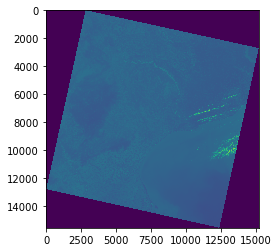

In [15]:
plt.imshow(landsat_data.data.squeeze())

In [16]:
variable = landsat_data.isel(band=0)

In [17]:
variable

<xarray.DataArray (y: 15541, x: 15221)>
dask.array<getitem, shape=(15541, 15221), dtype=uint16, chunksize=(15541, 15221), chunktype=numpy.ndarray>
Coordinates:
    band     int64 1
  * y        (y) float64 2.512e+06 2.512e+06 2.512e+06 ... 2.279e+06 2.279e+06
  * x        (x) float64 3.822e+05 3.822e+05 3.822e+05 ... 6.105e+05 6.105e+05
Attributes:
    transform:      (15.0, 0.0, 382192.5, 0.0, -15.0, 2512507.5)
    crs:            +init=epsg:32645
    res:            (15.0, 15.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Point

In [ ]:
# Crashes Kernel
variable.plot()

In [16]:
# Crashes Kernel
landsat_data.plot()

KeyboardInterrupt: 

## Try loading with Intake

Need to open_rasterio or open_xarray_image

Look at .container of that object

Call .read() on that to load it in.

Nothing can get around the DOS bomb error, will try again when i can get the cluster working again.

In [34]:
landsat_data = intake.open_xarray_image(landsat_data_url, chunks=(1000,1000))
landsat_data

In [35]:
landsat_data.container

'xarray'

In [37]:
landsat_data.to_dask()

DecompressionBombError: Image size (236549561 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.

In [36]:
for chunk in landsat_data.read_chunked():
    print('Chunk %d' % len(chunk))

DecompressionBombError: Image size (236549561 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.

In [23]:
landsat_data.read_chunked()

DecompressionBombError: Image size (236549561 pixels) exceeds limit of 178956970 pixels, could be decompression bomb DOS attack.